In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



读取处理过的数据，保留数据齐全的数据，调整时间格式

In [34]:
#df = pd.read_excel('MicroRV_CW.xlsx')
#df = pd.read_excel('micro_rv_usd.xlsx')
#df = pd.read_excel('micro_rv_euro.xlsx')
df = pd.read_excel('micro_rv_jpy.xlsx')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)

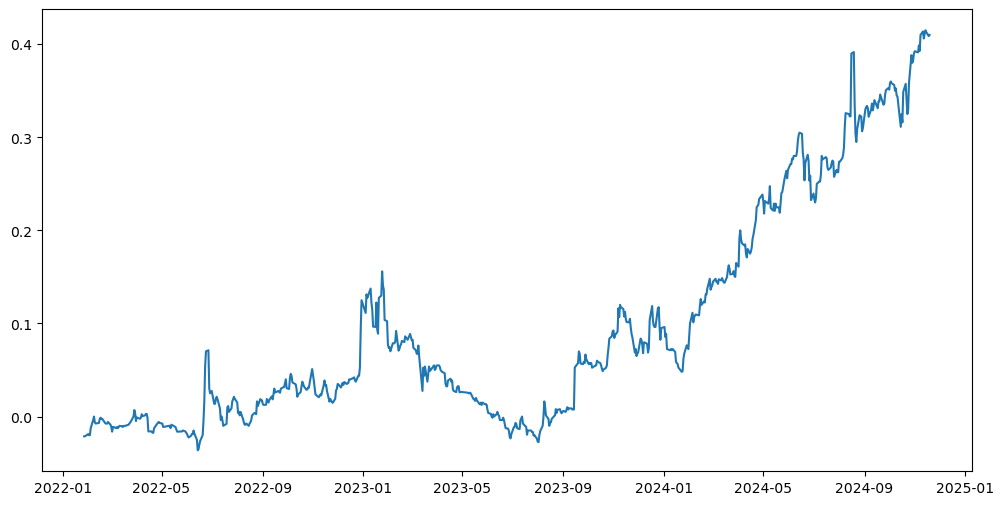

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[:,11])

In [36]:
def data_preprocess(df,type='gbp'):
    if type == 'gbp':
        columns = ['1W','2W']
        for i in [1,2,5,6,7,8,9,10,11]:
            columns.append(str(i)+'M')
        columns.append('1Y')
        columns.append('18M')
        for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
            columns.append(str(i)+'Y')
    
    elif type == 'euro':
        columns = ['1w','2w']
        for i in [1,2,3,4,5,6,7,8,9,10,11]:
            columns.append(str(i)+'M')
        columns.append('1Y')
        columns.append('18M')


        for i in [2,3,4,5,6,7,8,9,10,11,12,15,20,25,30,40,50]:
            columns.append(str(i)+'Y')
    
    elif type =='usd':
        columns = []
        for i in [1,2,3]:
            columns.append(str(i)+'W')
        for i in [1,2,3,4,5,6,7,8,9,10,11]:
            columns.append(str(i)+'M')
        columns.append('1Y')
        columns.append('18M')


        for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
            columns.append(str(i)+'Y')
            
    else:
        columns = []
        for i in [1,2]:
            columns.append(str(i)+'W')
        for i in [1,2,5,6,7,8,9,10,11]:
            columns.append(str(i)+'M')
        columns.append('1Y')
        columns.append('18M')


        for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40]:
            columns.append(str(i)+'Y')

    for old_name, new_name in zip(df.columns, columns):
        df.rename(columns={old_name: new_name}, inplace=True)
    
    return df

In [37]:
df = data_preprocess(df, 'jpy')

In [38]:
df

,1W,2W,1M,2M,5M,6M,7M,8M,9M,10M,...,7Y,8Y,9Y,10Y,12Y,15Y,20Y,25Y,30Y,40Y
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,-0.02300,-0.02310,-0.02375,-0.023800,-0.023900,-0.023750,-0.024720,-0.024470,-0.022500,-0.023210,...,0.08250,0.10700,0.13125,0.15690,0.20500,0.282500,0.400000,0.492500,0.562500,0.60750
2022-01-28,-0.02250,-0.02300,-0.02375,-0.023750,-0.023750,-0.023750,-0.023350,-0.023000,-0.022500,-0.022220,...,0.08625,0.10900,0.13375,0.16300,0.20750,0.286250,0.402500,0.495000,0.566250,0.61125
2022-01-31,-0.02250,-0.02296,-0.02300,-0.023000,-0.022500,-0.022500,-0.022000,-0.021250,-0.021250,-0.020810,...,0.09125,0.11500,0.13950,0.17010,0.21625,0.296880,0.416880,0.510000,0.582500,0.62750
2022-02-01,-0.02166,-0.02200,-0.02200,-0.022480,-0.021720,-0.021250,-0.020730,-0.020000,-0.020000,-0.019750,...,0.10000,0.12125,0.14625,0.17500,0.22250,0.306000,0.430000,0.522500,0.598000,0.64950
2022-02-02,-0.02100,-0.02100,-0.02125,-0.021250,-0.021250,-0.021250,-0.021240,-0.021190,-0.021020,-0.021060,...,0.08750,0.11250,0.13875,0.16880,0.21625,0.300000,0.423750,0.521000,0.597500,0.64500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13,0.22625,0.22700,0.22700,0.259095,0.311765,0.330000,0.349885,0.361000,0.376565,0.395235,...,0.78125,0.84250,0.90625,0.97500,1.09875,1.278750,1.528750,1.668750,1.747500,1.85750
2024-11-14,0.22625,0.22625,0.22750,0.270705,0.315555,0.329000,0.348825,0.365890,0.378750,0.391220,...,0.77625,0.84625,0.90375,0.97000,1.09625,1.276250,1.527500,1.666250,1.745000,1.84500
2024-11-15,0.22750,0.22650,0.22700,0.272405,0.312055,0.332135,0.365145,0.362715,0.379225,0.405505,...,0.76875,0.82750,0.88750,0.95125,1.07000,1.256000,1.510000,1.621250,1.732000,1.80750


将各期限转为年为单位，并构建dictionary

In [39]:
def transfer_dict_construct(df,type='gbp'):
    if type == 'gbp':
        tenors = np.array([1/52, 2/52, 1/12, 2/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50])
    elif type == 'usd':
        tenors = np.array([1/52,2/52,3/52,1/12,2/12,3/12,4/12,5/12,6/12, 7/12, 8/12, 9/12, 10/12,11/12, 12/12,  18/12,  2, 3, 4, 5, 6, 7, 8, 9, 10,12, 15, 20, 25, 30, 40, 50])
    elif type == 'euro':
        tenors = np.array([1/52,2/52,1/12,2/12,3/12,4/12,5/12,6/12, 7/12, 8/12, 9/12, 10/12,11/12, 12/12, 18/12,  2, 3, 4, 5, 6, 7, 8, 9, 10,11,12, 15, 20, 25, 30, 40, 50])
    else:
        tenors = np.array([1/52,2/52,1/12,2/12,5/12,6/12, 7/12, 8/12, 9/12, 10/12,11/12, 12/12,  18/12,  2, 3, 4, 5, 6, 7, 8, 9, 10,12, 15, 20, 25, 30, 40])
    
    # a dictionary that match column names to tenors
    tenors_dict = dict(zip(df.columns, tenors))
    # fit a hermite spline to first row with selected tenors
    selected_tenors = df.columns # select some tenors not all to show that the curve is interpolated
    x = np.array([tenors_dict[i] for i in selected_tenors])
    date = df.index[0]
    y = df.loc[date, selected_tenors].values
    return x,y

In [40]:
x,y = transfer_dict_construct(df, 'jpy')

In [41]:
x

array([1.92307692e-02, 3.84615385e-02, 8.33333333e-02, 1.66666667e-01,
       4.16666667e-01, 5.00000000e-01, 5.83333333e-01, 6.66666667e-01,
       7.50000000e-01, 8.33333333e-01, 9.16666667e-01, 1.00000000e+00,
       1.50000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
       5.00000000e+00, 6.00000000e+00, 7.00000000e+00, 8.00000000e+00,
       9.00000000e+00, 1.00000000e+01, 1.20000000e+01, 1.50000000e+01,
       2.00000000e+01, 2.50000000e+01, 3.00000000e+01, 4.00000000e+01])

In [42]:
y

array([-0.023  , -0.0231 , -0.02375, -0.0238 , -0.0239 , -0.02375,
       -0.02472, -0.02447, -0.0225 , -0.02321, -0.02221, -0.02125,
       -0.015  , -0.0056 ,  0.01125,  0.0285 ,  0.045  ,  0.0645 ,
        0.0825 ,  0.107  ,  0.13125,  0.1569 ,  0.205  ,  0.2825 ,
        0.4    ,  0.4925 ,  0.5625 ,  0.6075 ], dtype=float32)

In [ ]:
#gbp/usd
date = df.index[0]
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(1/52,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline',color='black')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date} using different methods')
plt.ylabel('Rate (%)')
plt.savefig("Example1.pdf",format = "pdf")

In [ ]:
#euro
date = df.index[0]
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(6/12,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date} using different methods')
plt.ylabel('Rate (%)')
plt.savefig("Example1.pdf",format = "pdf")

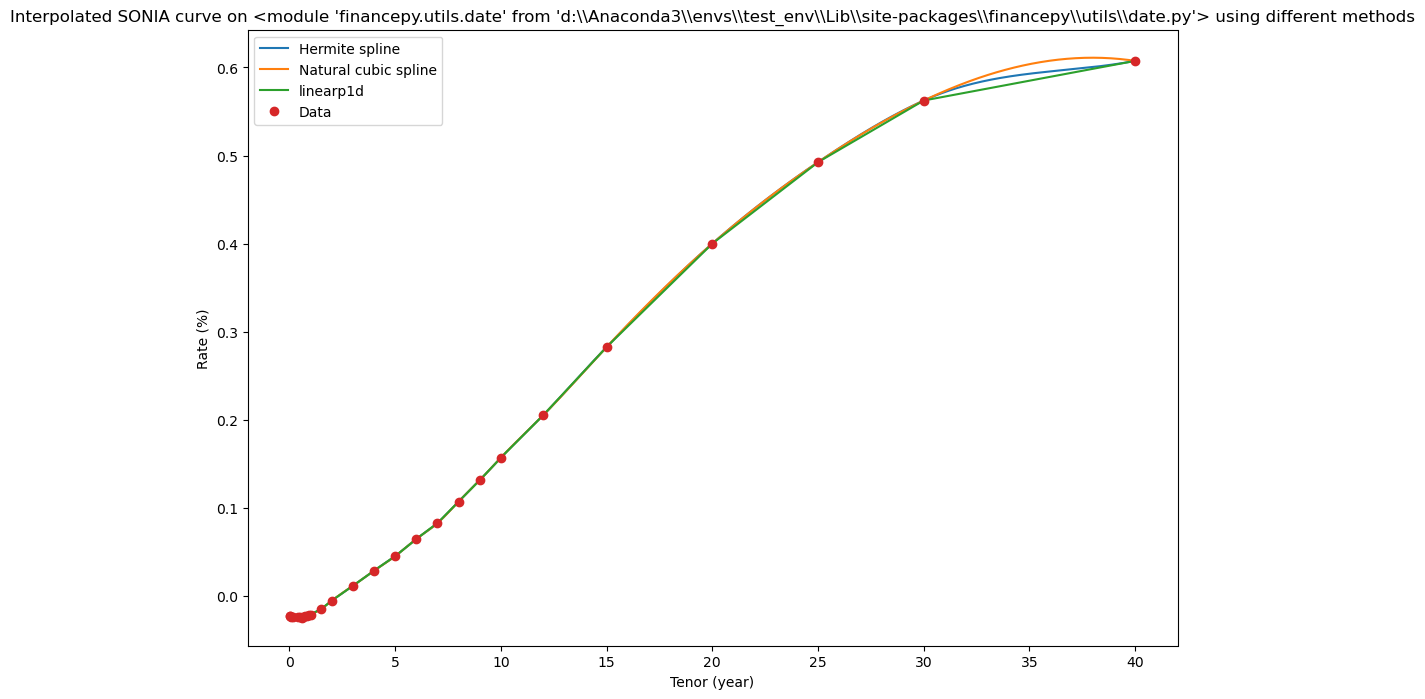

In [ ]:
#jpy
date = df.index[0]
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(1/52,40,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date} using different methods')
plt.ylabel('Rate (%)')
plt.savefig("Example1.pdf",format = "pdf")

In [29]:
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

In [30]:
def curvefit_demo(df,type='gbp'):
    if type == 'gbp':
        # Demonstrate fitting a curve using the first date
        valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
        spot_days = 0 # T+0 as shown in Bloomberg ticker
        settlement_date = valuation_date.add_weekdays(spot_days)
        cal = CalendarTypes.UNITED_KINGDOM
        # store SONIA swap as we only have swap as benchmark instruments
        swaps = []
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_365F # 365 fixed

    elif type == 'usd':
        # Demonstrate fitting a curve using the first date
        valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
        spot_days = 0 # T+0 as shown in Bloomberg ticker
        settlement_date = valuation_date.add_weekdays(spot_days)
        cal = CalendarTypes.UNITED_STATES
        # store SONIA swap as we only have swap as benchmark instruments
        swaps = []
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_360 

    elif type == 'euro':
        # Demonstrate fitting a curve using the first date
        valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
        spot_days = 0 # T+0 as shown in Bloomberg ticker
        settlement_date = valuation_date.add_weekdays(spot_days)
        cal = CalendarTypes.TARGET
        # store SONIA swap as we only have swap as benchmark instruments
        swaps = []
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_360 
    
    else:
        # Demonstrate fitting a curve using the first date
        valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
        spot_days = 0 # T+0 as shown in Bloomberg ticker
        settlement_date = valuation_date.add_weekdays(spot_days)
        cal = CalendarTypes.JAPAN
        # store SONIA swap as we only have swap as benchmark instruments
        swaps = []
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_365F 
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_365F 

    for tenor in df.columns:
        if tenor[-1]=='Y': # only append yearly tenors for swap
            rate = df.loc[df.index[0], tenor]/100 # convert to %
            swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
            swaps.append(swap)

    curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES) 
    plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
    plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")}  for different rates')

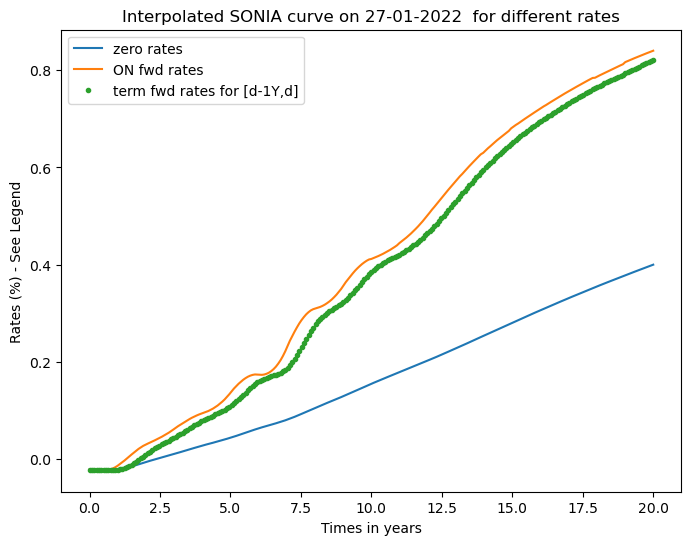

In [45]:
curvefit_demo(df,type='jpy')

In [32]:
def curvefit(df,type='gbp'):
    # create a yield curve dataset with columns in years, and rows same as df.index
    # create a curves dictionary to store the calibrated curve for each date
    curves = {}
    year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
    year_columns = [int(i[:-1]) for i in year_columns] # convert to int
    df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y

    if type == 'gbp':
        # swap characteristics
        cal = CalendarTypes.UNITED_KINGDOM
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_365F # 365 fixed
    
    elif type  == 'jpy':
        # swap characteristics
        cal = CalendarTypes.JAPAN
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
        fixedFreqType = FrequencyTypes.ANNUAL # annual
        floatFreqType = FrequencyTypes.ANNUAL # annual
        floatDCCType = DayCountTypes.ACT_365F # 365 fixed
    
    elif type == 'usd':
        # swap characteristics
        cal = CalendarTypes.UNITED_STATES
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL
        floatFreqType = FrequencyTypes.ANNUAL 
        floatDCCType = DayCountTypes.ACT_360 
    
    else:
        # swap characteristics
        cal = CalendarTypes.TARGET
        swapType = SwapTypes.PAY # pay fixed
        fixedDCCType = DayCountTypes.ACT_360 
        fixedFreqType = FrequencyTypes.ANNUAL
        floatFreqType = FrequencyTypes.ANNUAL 
        floatDCCType = DayCountTypes.ACT_360 
        
    for date in tqdm(df.index, desc='Creating curves'): # loop through each date in the dataset
        swaps = []
        day, month, year = date.day, date.month, date.year
        valuation_date = Date(day, month, year) # convet to Date object
        spot_days = 0 # T+0
        settlement_date = valuation_date.add_weekdays(spot_days)
        for tenor in df.columns: # loop through each tenor in the dataset
            if tenor[-1]=='Y':
                rate = df.loc[date, tenor]/100
                swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                                fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                                float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
                swaps.append(swap)

        curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES)
        for year in year_columns:
            df_yield.loc[date, year] = curve.swap_rate(effective_dt=valuation_date,maturity_dt=valuation_date.add_years(year))
        curves[date] = curve # add this curve to the dictionary

    return curves, df_yield

In [ ]:
curves, df_yield = curvefit(df,type='jpy')

### butterfly

In [ ]:
with open('curves.pkl', 'rb') as f:
    curves = pickle.load(f)  
df_yield = pd.read_pickle('df_yield.pkl')

In [13]:
def swap_dv01(curve, start_date, maturity_date):
    """根据贴现现金流估算 swap DV01"""
    try:
        tau = 1  # annual accrual
        d = start_date.add_years(1)
        payment_dates = []
        while d <= maturity_date:
            payment_dates.append(d)
            d = d.add_years(1)
        discount_factors = [curve.df(p) for p in payment_dates]
        return sum(tau * df for df in discount_factors)
    except:
        return np.nan

In [14]:
# z = 2 * rb - ra - rc
def compute_fly_from_curves(curves, fly_legs, window=60, rate_type='zero',K=15):
    """
    根据已拟合好的 financepy curves，计算给定 butterfly 结构的 fly spread 、 z-score 和 carry。

    参数:
    - curves: dict[Date] → IborSingleCurve
    - fly_legs: list of (a,b,c) tuples，代表不同的 fly 结构（单位：年）
    - window: 滚动窗口长度（单位：天数）
    - rate_type: 'zero' 或 'forward'，表示从 curve 中提取哪种利率计算 fly

    返回:
    - fly_df: 每天每个结构的 fly spread
    - zscore_df: 每天每个结构的 z-score
    - carry_df: 每天每个结构的 carry
    """

    fly_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    zscore_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs} # z-score
    carry_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs} # carry
    dates = list(curves.keys())[0:21*K] # 252/12 = 21
    dates.sort()

    for idx in range(window, len(dates)):
        current_date = dates[idx]
        current_curve = curves[current_date]

        past_fly_dict = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}

        # 过去窗口内的 fly spread 序列
        for hist_date in dates[idx - window: idx]:
            hist_curve = curves[hist_date]
            for (a, b, c) in fly_legs:
                d_a = Date(hist_date.day, hist_date.month, hist_date.year).add_years(a)
                d_b = Date(hist_date.day, hist_date.month, hist_date.year).add_years(b)
                d_c = Date(hist_date.day, hist_date.month, hist_date.year).add_years(c)

                if rate_type == 'zero':
                    try:
                        ra = hist_curve.zero_rate(d_a)
                        rb = hist_curve.zero_rate(d_b)
                        rc = hist_curve.zero_rate(d_c)
                    except:
                        continue
                elif rate_type == 'forward':
                    try:
                        ra = hist_curve.fwd(d_a)
                        rb = hist_curve.fwd(d_b)
                        rc = hist_curve.fwd(d_c)
                    except:
                        continue
                else:
                    raise ValueError("rate_type must be 'zero' or 'forward'")

                fly_hist = 2 * rb - ra - rc
                past_fly_dict[f"{a}-{b}-{c}"].append(fly_hist)

        # 当前日期的 fly 和 z-score 和 carry
        for (a, b, c) in fly_legs:
            d_a = Date(current_date.day, current_date.month, current_date.year).add_years(a)
            d_b = Date(current_date.day, current_date.month, current_date.year).add_years(b)
            d_c = Date(current_date.day, current_date.month, current_date.year).add_years(c)

            try:
                if rate_type == 'zero':
                    ra = current_curve.zero_rate(d_a)
                    rb = current_curve.zero_rate(d_b)
                    rc = current_curve.zero_rate(d_c)
                else:
                    ra = current_curve.fwd(d_a)
                    rb = current_curve.fwd(d_b)
                    rc = current_curve.fwd(d_c)

                fly_today = 2 * rb - ra - rc
                fly_data[f"{a}-{b}-{c}"].append(fly_today)

                hist_vals = past_fly_dict[f"{a}-{b}-{c}"]
                if len(hist_vals) >= 5:
                    mu = np.mean(hist_vals)
                    sigma = np.std(hist_vals)
                    z = float((fly_today - mu) / sigma) if sigma > 1e-6 else 0
                else:
                    z = np.nan
                zscore_data[f"{a}-{b}-{c}"].append(z)

                # --------------------------
                # 计算Carry（DV01中性调整）
                # --------------------------
                # 定义参数
                notional_base = 1e6
                start_date = Date(current_date.day, current_date.month, current_date.year)

                # 计算各leg DV01
                def get_dv01(tenor):
                    maturity = start_date.add_years(tenor)
                    return swap_dv01(current_curve, start_date, maturity)

                dv01_a = get_dv01(a)
                dv01_b = get_dv01(b)
                dv01_c = get_dv01(c)
                direction_a = 1  # 两侧Leg为payer，carry符号为+（L - k）
                direction_b = -1   # 中间Leg为receiver，carry符号为（k - L）
                direction_c = 1

                # 调整中间leg名义本金以实现DV01中性
                notional_a = notional_c = notional_base
                notional_b = (notional_a * dv01_a + notional_c * dv01_c) / (2 * dv01_b)

                # 计算各leg Carry
                def compute_leg_carry(tenor, notional, direction):
                    maturity = start_date.add_years(tenor)
                    try:
                        L = current_curve.fwd(maturity)  # 浮动利率
                        k = current_curve.swap_rate(start_date, maturity)  # 固定利率
                        tau = 1 if tenor >= 1 else tenor  
                        return notional * tau * (L - k) *direction
                    except:
                        return np.nan

                carry_a = compute_leg_carry(a, notional_a, direction_a)
                carry_b = compute_leg_carry(b, notional_b, direction_b)
                carry_c = compute_leg_carry(c, notional_c, direction_c)

                # Butterfly Carry = 2*carry_b - carry_a - carry_c
                carry_today = float(2 * carry_b + carry_a + carry_c)
                carry_data[f"{a}-{b}-{c}"].append(carry_today)

            except:
                fly_data[f"{a}-{b}-{c}"].append(np.nan)
                zscore_data[f"{a}-{b}-{c}"].append(np.nan)
                carry_data[f"{a}-{b}-{c}"].append(np.nan)

    fly_df = pd.DataFrame(fly_data, index=dates[window:])
    zscore_df = pd.DataFrame(zscore_data, index=dates[window:])
    carry_df = pd.DataFrame(carry_data, index=dates[window:])
    return fly_df, zscore_df,carry_df

In [42]:
fly_legs = [(2, 5, 10), (5, 10, 30), (3, 5, 7),(1,4,7),(1,3,5),(10,20,30)]
rollingwindows = [21,42,63,84,105,126]  #day, 相当于 1 2 3 4 5 6个月,try different k
fly_dfs = {}
z_dfs = {}
carry_dfs = {}

for window in rollingwindows:
    fly_df, z_df, carry_df = compute_fly_from_curves(
        curves, 
        fly_legs, 
        window=window, 
        rate_type='forward', 
        K=15
    )
    
    # 以窗口大小为键存储结果
    fly_dfs[f"window_{window}"] = fly_df
    z_dfs[f"window_{window}"] = z_df
    carry_dfs[f"window_{window}"] = carry_df

In [ ]:
carry_dfs[f"window_{126}"]

,2-5-10,5-10-30,3-5-7,1-4-7,1-3-5,10-20-30
2022-04-22,14406.780555,-4017.082278,-130.249143,532.102512,8217.961604,-1316.591789
2022-04-25,12387.962213,-3023.960371,-1494.799141,1347.883921,10824.364510,6.554856
2022-04-26,11193.836060,-1748.322223,-244.604381,2185.568113,6585.828967,591.169339
2022-04-27,8862.248257,1764.667408,-30.776696,3089.303934,5973.017986,926.298368
2022-04-28,8662.472984,-911.781175,514.883754,4698.315894,2909.172419,1008.676020
...,...,...,...,...,...,...
2023-04-21,5920.627003,-6198.537569,1237.989400,4044.991738,2631.610731,-3923.024655
2023-04-24,6642.121912,-7609.097527,1518.673320,4260.228024,2450.231158,-4234.189003
2023-04-25,6397.589253,-4818.791448,1794.915435,3701.441140,2009.784850,-1682.370140
2023-04-26,6309.221065,-8308.102595,2019.945943,4036.538840,2502.556028,-3296.606134


In [ ]:
def select_best_trades(z_df, carry_df, n_z=100, carry_percent=0.3):
    """
    筛选策略:先选z-score绝对值前n_z的交易,再从中选carry值在整个数据集前carry_percent%的交易
    
    参数:
    - z_df: DataFrame，每列为交易结构，值为z-score
    - carry_df: DataFrame，每列为交易结构，值为carry（需与z_df同索引、同列）
    - n_z: 第一步筛选的z-score数量
    - carry_percent: 筛选carry在整个数据集的前百分比（如0.3表示前30%）
    
    返回:
    - selected_trades: DataFrame，包含最终选中的交易及其z-score和carry值
    """
    
    # 1. 筛选z-score绝对值前n_z的交易
    z_flat = z_df.stack().rename('z_score')
    top_z = z_flat.abs().nlargest(n_z).index  # 获取前n_z的索引（日期, 交易结构）
    
    # 2. 计算整个数据集的carry前30%阈值
    carry_flat = carry_df.stack().dropna()
    carry_threshold = carry_flat.quantile(1 - carry_percent)
    
    # 3. 在top_z中筛选carry超过全局阈值的交易
    carry_subset = carry_flat.loc[top_z]
    mask = carry_subset >= carry_threshold
    selected_index = carry_subset[mask].index
    
    # 4. 合并结果（包含z-score和carry）
    selected = pd.concat([z_flat.loc[selected_index], carry_flat.loc[selected_index]], axis=1)
    selected.columns = ['z_score', 'carry']
    
    return selected.sort_values(by='z_score', ascending=False)

In [55]:
best_trades_dfs = {}
for window in rollingwindows:
    z_df = z_dfs[f"window_{window}"]
    carry_df = carry_dfs[f"window_{window}"]
    best_trades = select_best_trades(z_df, carry_df, n_z=50, carry_percent=0.5)
    best_trades_dfs[f'window_{window}'] = best_trades
    print(f"满足条件的交易数量: {len(best_trades)},window={window}")
    print(best_trades.head())

满足条件的交易数量: 21,window=21
                    z_score        carry
2022-04-20 2-5-10  6.787666  7777.074979
2022-04-15 2-5-10  4.883585  9574.336124
2023-03-15 1-4-7   3.673499  3207.498352
2023-03-14 1-4-7   3.670858  3835.706115
2022-12-21 2-5-10  3.346148  4724.065579
满足条件的交易数量: 20,window=42
                      z_score         carry
2022-04-20 2-5-10    5.756891   7777.074979
2022-05-16 2-5-10    3.980653   5831.648693
           10-20-30 -3.347106   3313.699297
2022-08-17 1-4-7    -3.511073  13064.861668
2022-09-29 3-5-7    -3.511246  12411.299642
满足条件的交易数量: 23,window=63
                    z_score         carry
2022-05-16 2-5-10  4.479021   5831.648693
2022-06-09 2-5-10  3.589727   5463.920575
2022-06-06 3-5-7  -3.177335   3988.179209
2022-06-14 3-5-7  -3.276277   4970.589654
2022-09-30 2-5-10 -3.283547  33994.103735
满足条件的交易数量: 20,window=84
                     z_score         carry
2022-06-09 2-5-10   4.070839   5463.920575
2022-06-10 2-5-10   3.324453   6767.211352
2022-06-23 2-

In [18]:
'''
now no use
def select_best_trades(criteria_computed,N=10):
    z_flat = criteria_computed.stack().dropna()  # 把 z_df 转成长表
    return z_flat[z_flat.abs().sort_values(ascending=False).head(N).index] # 按照绝对值排序

best_10_trades = select_best_trades(z_df_forward,100)
best_10_trades
'''

'\nnow no use\ndef select_best_trades(criteria_computed,N=10):\n    z_flat = criteria_computed.stack().dropna()  # 把 z_df 转成长表\n    return z_flat[z_flat.abs().sort_values(ascending=False).head(N).index] # 按照绝对值排序\n\nbest_10_trades = select_best_trades(z_df_forward,100)\nbest_10_trades\n'

In [19]:
def simulate_fly_pnl_dv01(start_date, structure, curves, notional=1e6):
    """
    基于 swap DV01 模拟 fly spread 的 PnL
    
    参数:
    - start_date: 信号触发日期（开仓）
    - structure: tuple (a,b,c)，表示 fly: 2b - a - c
    - curves: dict[pd.Timestamp] → IborSingleCurve
    - notional: 每条leg的名义本金，默认 100 万
    
    返回:
    - pnl_series: 每天的 fly 结构的累计 PnL
    - leg_pnls: 每条leg的单独 PnL 路径
    """
    a, b, c = structure
    all_dates = sorted([d for d in curves if d >= start_date])
    if len(all_dates) == 0:
        return None, None

    # 起始日期 & 每条leg的 maturity
    d0 = start_date
    d0_date = Date(d0.day, d0.month, d0.year)
    mty_a = d0_date.add_years(a)
    mty_b = d0_date.add_years(b)
    mty_c = d0_date.add_years(c)

    curve_0 = curves[d0]

    # 开仓时每条leg的 swap rate 和 DV01
    legs = {
        'a': {'mty': mty_a, 'sign': -1},
        'b1': {'mty': mty_b, 'sign': 2},
        'c': {'mty': mty_c, 'sign': -1},
    }

    for key, leg in legs.items():
        leg['rate_open'] = curve_0.swap_rate(d0_date, leg['mty'])
        leg['dv01'] = swap_dv01(curve_0, d0_date, leg['mty'])

    legs['a']['notional'] = notional
    legs['c']['notional'] = notional
    legs['b1']['notional'] = (notional * legs['a']['dv01'] + notional * legs['c']['dv01']) / (2 * legs['b1']['dv01'])
    #print(legs['b1']['notional'])

    # 模拟持仓期间的每日 PnL
    pnl_data = {k: [] for k in legs}
    total_pnl = []

    for d in all_dates:
        curve = curves[d]
        d_date = Date(d.day, d.month, d.year)
        daily_pnl = 0
        for key, leg in legs.items():
            try:
                rate_now = curve.swap_rate(d_date, leg['mty']) #maturity在变，attention！
                rate_diff = rate_now - leg['rate_open']
                leg_pnl = float(rate_diff * leg['dv01'] * leg['notional'] * leg['sign'])
                pnl_data[key].append(leg_pnl)
                daily_pnl += leg_pnl
            except:
                pnl_data[key].append(np.nan)
                daily_pnl = np.nan
        total_pnl.append(daily_pnl)

    pnl_series = pd.Series(total_pnl, index=all_dates)
    leg_pnls = pd.DataFrame(pnl_data, index=all_dates)
    return pnl_series, leg_pnls

In [32]:
def backtest_top_n_fly_trades_dv01(top_signals, curves, notional=1e6):
    """
    使用 DV01 精确计算每个交易的 PnL

    参数：
    - top_signals: 选出来的top trades
    - curves: dict[pd.Timestamp] → IborSingleCurve
    - notional: 每条leg的名义本金

    返回：
    - result_df: 每笔交易的明细
    - summary: 总结
    """
    records = []

    for (date, structure_str) in top_signals.index:
        z_score,carry = best_trades.loc[date, structure_str]
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1  # 正z做空fly，负z做多fly

        try:
            pnl_series, leg_pnls = simulate_fly_pnl_dv01(date, structure, curves, notional=notional)
            if pnl_series is None or pnl_series.dropna().empty:
                continue

            adjusted_pnl = direction * pnl_series
            final_pnl = adjusted_pnl.dropna().iloc[-1] #到期or最后一天pnl
            max_drawdown = (adjusted_pnl.cummax() - adjusted_pnl).max()

            records.append({
                'start_date': date,
                'structure': structure_str,
                'z_score': z_score,
                'carry':carry,
                'direction': 'short fly' if z_score > 0 else 'long fly',
                'final_pnl': final_pnl,
                'max_drawdown': max_drawdown,
                'duration': len(adjusted_pnl)
            })
        except Exception as e:
            continue

    result_df = pd.DataFrame(records)
    
    summary = {
        'Total Trades': len(result_df),
        'Win Ratio': (result_df['final_pnl'] > 0).mean(),
        'Average PnL': result_df['final_pnl'].mean(),
        'Average Max Drawdown': result_df['max_drawdown'].mean(),
        'Average Duration': result_df['duration'].mean()
    }
    
    return result_df, summary

In [56]:
results = {}
summaries = {}
for window in rollingwindows:
    best_trades = best_trades_dfs[f"window_{window}"]
    result, summary = backtest_top_n_fly_trades_dv01(best_trades, curves, notional=1e6)
    results[f"window_{window}"] = result
    summaries[f"window_{window}"] = summary

In [57]:
results[f"window_{42}"]

,start_date,structure,z_score,carry,direction,final_pnl,max_drawdown,duration
0,2022-04-20,2-5-10,5.756891,7777.074979,short fly,-4613.447897,102396.749030,658
1,2022-05-16,2-5-10,3.980653,5831.648693,short fly,-503.987304,111435.791305,641
2,2022-05-16,10-20-30,-3.347106,3313.699297,long fly,5486.615522,436769.921754,641
3,2022-08-17,1-4-7,-3.511073,13064.861668,long fly,20536.241970,30373.134036,577
4,2022-09-29,3-5-7,-3.511246,12411.299642,long fly,15179.152720,36795.583026,548
5,2022-06-09,10-20-30,-3.532640,2812.527352,long fly,20792.250752,412741.633059,625
6,2022-09-27,1-4-7,-3.683029,22105.353755,long fly,-8260.905663,27806.452648,550
7,2022-05-16,1-4-7,-3.730336,5680.179746,long fly,10670.039525,49199.655200,641
8,2022-05-17,3-5-7,-3.742069,3992.124504,long fly,1719.005555,50840.628369,640
9,2022-06-23,1-3-5,-3.858974,24661.339886,long fly,21299.405354,19836.115169,615


In [58]:
summaries[f"window_{105}"]

{'Total Trades': 24,
 'Win Ratio': 0.6666666666666666,
 'Average PnL': 733.931729869311,
 'Average Max Drawdown': 62979.963006243306,
 'Average Duration': 575.0}

In [62]:
plt.style.use('ggplot')

# Assume we have the data frames from the previous code
# fly_df_forward: DataFrame of butterfly spreads
# z_df_forward: DataFrame of z-scores
# best_10_trades: Series of the top 10 trades by absolute z-score
# result: DataFrame with backtest results for top trades

# 1. Z-Score Evolution Over Time
def plot_zscore_evolution(z_df, best_trades=None, title="Z-Score Evolution Over Time"):
    """Plot z-scores over time with highlights for filtered trades"""
    plt.figure(figsize=(14, 8))
    
    # Plot all z-scores as light lines
    for col in z_df.columns:
        plt.plot(z_df.index, z_df[col], alpha=0.3, linewidth=1, color='gray')

    legend_handles = []
    legend_labels = []
    
    # Highlight filtered trades
    if best_trades is not None and not best_trades.empty:
        structures_to_highlight = best_trades.index.get_level_values(1).unique()
        
        for structure in structures_to_highlight:
            if structure in z_df.columns:
                line, = plt.plot(z_df.index, z_df[structure], 
                               linewidth=2, 
                               label=f'_nolegend_')  
                if structure not in legend_labels:
                    legend_handles.append(line)
                    legend_labels.append(structure)
        
        scatter = None
        for (date, structure), _ in best_trades.iterrows():
            if structure in z_df.columns:
                scatter = plt.scatter(date, z_df.loc[date, structure],
                                    s=100, color='red', zorder=5,
                                    edgecolor='black', 
                                    label='Selected Trades' if not scatter else None)
        
        if scatter is not None and 'Selected Trades' not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append('Selected Trades')
    
    line_z2 = plt.axhline(y=2, color='red', linestyle='--', alpha=0.7)
    line_z_neg2 = plt.axhline(y=-2, color='red', linestyle='--', alpha=0.7)
    line_zero = plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    legend_handles.extend([line_z2, line_z_neg2, line_zero])
    legend_labels.extend(['Z = +2', 'Z = -2', 'Zero Line'])
    
    plt.legend(legend_handles, legend_labels, 
             loc='upper right', 
             bbox_to_anchor=(1.15, 1),
             frameon=True)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Z-Score', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 2. carry Evolution Over Time
def plot_carry_evolution(carry_df, best_trades=None, title="Carry Evolution Over Time"):
    """Plot carry values over time with highlights for filtered trades"""
    plt.figure(figsize=(14, 8))
    
    # Plot all carry values as light lines
    for col in carry_df.columns:
        plt.plot(carry_df.index, carry_df[col], alpha=0.3, linewidth=1, color='gray')

    legend_handles = []
    legend_labels = []
    
    # Highlight filtered trades
    if best_trades is not None and not best_trades.empty:
        structures_to_highlight = best_trades.index.get_level_values(1).unique()
        
        for structure in structures_to_highlight:
            if structure in carry_df.columns:
                line, = plt.plot(carry_df.index, carry_df[structure], 
                               linewidth=2, 
                               label=f'_nolegend_')  
                if structure not in legend_labels:
                    legend_handles.append(line)
                    legend_labels.append(structure)
        
        scatter = None
        for (date, structure), _ in best_trades.iterrows():
            if structure in carry_df.columns:
                scatter = plt.scatter(date, carry_df.loc[date, structure],
                                    s=100, color='blue', zorder=5,
                                    edgecolor='black', 
                                    label='Selected Trades' if not scatter else None)
        
        if scatter is not None and 'Selected Trades' not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append('Selected Trades')
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.legend(legend_handles, legend_labels, 
             loc='upper right', 
             bbox_to_anchor=(1.15, 1),
             frameon=True)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Carry Value', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 3. Butterfly Spread Evolution
def plot_fly_evolution(fly_df, title="Butterfly Spread Evolution"):
    """Plot butterfly spreads over time"""
    plt.figure(figsize=(12, 6))
    
    for col in fly_df.columns:
        plt.plot(fly_df.index, fly_df[col] * 10000, label=col)  # Convert to basis points
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Spread (bps)', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 4. PnL Evolution for Top Trades
def plot_pnl_evolution(result, curves, best_trades, notional=1e6):
    """Plot PnL evolution for dynamic number of trades"""
    plt.figure(figsize=(14, 8))
    
    n_trades = len(best_trades)
    colors = plt.cm.viridis(np.linspace(0, 1, n_trades))
    
    # 检查输入类型
    if isinstance(best_trades, pd.DataFrame):
        # 处理包含多列的DataFrame
        iterator = best_trades['z_score'].items()
    else:
        # 处理Series
        iterator = best_trades.items()

    for i, ((start_date, structure_str), z_score) in enumerate(iterator):
        # 动态处理不同结构
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1
        
        # 模拟PnL
        pnl_series, _ = simulate_fly_pnl_dv01(start_date, structure, curves, notional)
        if pnl_series is not None and not pnl_series.empty:
            adjusted_pnl = direction * pnl_series #.cumsum()
            plt.plot(adjusted_pnl.index, adjusted_pnl.values,
                     label=f"{structure_str} ({start_date.strftime('%Y-%m')})",
                     color=colors[i], linewidth=1.5, alpha=0.8)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title('PnL Evolution for Top Trades', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('PnL ($)', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 5. Trade Performance Summary
def plot_trade_performance(result):
    """Visualize the performance metrics of the trades"""
    if len(result) == 0:
        return None
    
    # 根据交易数量调整可视化参数
    n_trades = len(result)
    fig = plt.figure(figsize=(15, 10 + n_trades*0.2))  # 动态调整高度
    
    # 根据交易数量选择布局
    if n_trades <= 20:
        gs = gridspec.GridSpec(5, 2, figure=fig)
    else:
        gs = gridspec.GridSpec(6, 2, figure=fig)
    
    # 1. PnL Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(result['final_pnl'], bins=10, kde=True, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Final PnL', fontsize=14)
    ax1.set_xlabel('PnL ($)', fontsize=12)
    
    # 2. PnL by Structure
    ax2 = fig.add_subplot(gs[0, 1])
    avg_pnl_by_structure = result.groupby('structure')['final_pnl'].mean().sort_values()
    if len(avg_pnl_by_structure) > 15:
        ax2.tick_params(axis='x', rotation=90)
        plt.subplots_adjust(bottom=0.3)
    sns.barplot(x=avg_pnl_by_structure.index, y=avg_pnl_by_structure.values, ax=ax2)
    ax2.set_title('Average PnL by Structure', fontsize=14)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_ylabel('Average PnL ($)', fontsize=12)
    
    # 3. PnL vs Z-Score
    ax3 = fig.add_subplot(gs[1, 0])
    sns.scatterplot(x='z_score', y='final_pnl', data=result, s=70,hue='structure', ax=ax3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax3.set_title('Final PnL vs Z-Score', fontsize=14)
    ax3.set_xlabel('Z-Score at Entry', fontsize=12)
    ax3.set_ylabel('Final PnL ($)', fontsize=12)

    # 4. PnL vs carry
    ax4 = fig.add_subplot(gs[1, 1])
    sns.scatterplot(x='carry', y='final_pnl', data=result, 
                    s=70, hue='structure', ax=ax4)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_title('Final PnL vs Carry Value', fontsize=14)
    ax4.set_xlabel('Carry at Entry', fontsize=12)
    ax4.set_ylabel('Final PnL ($)', fontsize=12)
    
    # 5. PnL vs Duration
    ax5 = fig.add_subplot(gs[2, 0])
    sns.scatterplot(x='duration', y='final_pnl', data=result, s=70, ax=ax5)
    ax5.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax5.set_title('Final PnL vs Trade Duration', fontsize=14)
    ax5.set_xlabel('Duration (days)', fontsize=12)
    ax5.set_ylabel('Final PnL ($)', fontsize=12)
    
    # 6. Z-Score Distribution
    ax6 = fig.add_subplot(gs[2, 1])
    sns.boxplot(x='structure', y='z_score', data=result, ax=ax6)
    ax6.set_title('Z-Score Distribution by Structure', fontsize=14)
    ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)
    ax6.set_ylabel('Z-Score', fontsize=12)
    ax6.set_xlabel('')

    # 7. carry Distribution
    ax7 = fig.add_subplot(gs[3, 0])
    sns.boxplot(x='structure', y='carry', data=result, ax=ax7)
    ax7.set_title('carry Distribution by Structure', fontsize=14)
    ax7.set_xticklabels(ax7.get_xticklabels(), rotation=45)
    ax7.set_ylabel('carry', fontsize=12)
    ax7.set_xlabel('')

    # 8. Trade Summary Table
    ax8 = fig.add_subplot(gs[4, :])
    ax8.axis('tight')
    ax8.axis('off')
    
    # Create a performance summary
    win_rate = (result['final_pnl'] > 0).mean() * 100
    avg_win = result[result['final_pnl'] > 0]['final_pnl'].mean() if any(result['final_pnl'] > 0) else 0
    avg_loss = result[result['final_pnl'] < 0]['final_pnl'].mean() if any(result['final_pnl'] < 0) else 0
    profit_factor = abs(result[result['final_pnl'] > 0]['final_pnl'].sum() / 
                        result[result['final_pnl'] < 0]['final_pnl'].sum()) if result[result['final_pnl'] < 0]['final_pnl'].sum() != 0 else float('inf')
    
    summary_data = [
        ["Number of Trades", len(result)],
        ["Win Rate", f"{win_rate:.2f}%"],
        ["Average PnL", f"${result['final_pnl'].mean():.2f}"],
        ["Average Win", f"${avg_win:.2f}"],
        ["Average Loss", f"${avg_loss:.2f}"],
        ["Profit Factor", f"{profit_factor:.2f}"],
        ["Max PnL", f"${result['final_pnl'].max():.2f}"],
        ["Min PnL", f"${result['final_pnl'].min():.2f}"],
        ["Average Max Drawdown", f"${result['max_drawdown'].mean():.2f}"],
        ["Average Duration", f"{result['duration'].mean():.1f} days"]
    ]
    
    table = ax8.table(cellText=summary_data, colLabels=["Metric", "Value"], 
                      cellLoc='center', loc='center', cellColours=[['#f2f2f2']*2]*len(summary_data))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    plt.suptitle("Trade Performance Summary", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

# Function to generate a summary report
def generate_strategy_report(result, summary):
    """Generate a text summary of the trading strategy results"""
    if len(result) == 0:
        return "No valid trades were found in the analysis."
    
    # Calculate additional metrics
    winning_trades = result[result['final_pnl'] > 0]
    losing_trades = result[result['final_pnl'] < 0]
    
    win_count = len(winning_trades)
    loss_count = len(losing_trades)
    
    avg_win_amount = winning_trades['final_pnl'].mean() if win_count > 0 else 0
    avg_loss_amount = losing_trades['final_pnl'].mean() if loss_count > 0 else 0
    
    total_pnl = result['final_pnl'].sum()
    avg_pnl = result['final_pnl'].mean()
    
    # Format the report
    report = f"""
    Micro RV Trading Strategy Performance Report
    ============================================
    
    Overview:
    ---------
    Total Trades: {len(result)}
    Winning Trades: {win_count} ({win_count/len(result)*100:.1f}%)
    Losing Trades: {loss_count} ({loss_count/len(result)*100:.1f}%)
    
    Performance:
    ------------
    Total PnL: ${total_pnl:.2f}
    Average PnL per Trade: ${avg_pnl:.2f}
    Average Winning Trade: ${avg_win_amount:.2f}
    Average Losing Trade: ${avg_loss_amount:.2f}
    Profit Factor: {abs(winning_trades['final_pnl'].sum() / losing_trades['final_pnl'].sum()):.2f} if loss_count > 0 else "∞"
    
    Risk Metrics:
    ------------
    Average Maximum Drawdown: ${result['max_drawdown'].mean():.2f}
    Largest Drawdown: ${result['max_drawdown'].max():.2f}
    Average Trade Duration: {result['duration'].mean():.1f} days
    
    Structure Analysis:
    -----------------
    Best Performing Structure: {result.groupby('structure')['final_pnl'].mean().idxmax()} (Avg PnL: ${result.groupby('structure')['final_pnl'].mean().max():.2f})
    Worst Performing Structure: {result.groupby('structure')['final_pnl'].mean().idxmin()} (Avg PnL: ${result.groupby('structure')['final_pnl'].mean().min():.2f})
    
    Z-Score Analysis:
    ---------------
    Average Entry Z-Score (absolute): {result['z_score'].abs().mean():.2f}
    Best Z-Score Range: {result.groupby(pd.cut(result['z_score'].abs(), bins=3))['final_pnl'].mean().idxmax()}
    
    Conclusion:
    ----------
    The strategy {("was profitable" if total_pnl > 0 else "was not profitable")}, generating a total PnL of ${total_pnl:.2f} 
    across {len(result)} trades. The win rate was {win_count/len(result)*100:.1f}% with an average profit per trade of ${avg_pnl:.2f}.
    """
    
    return report

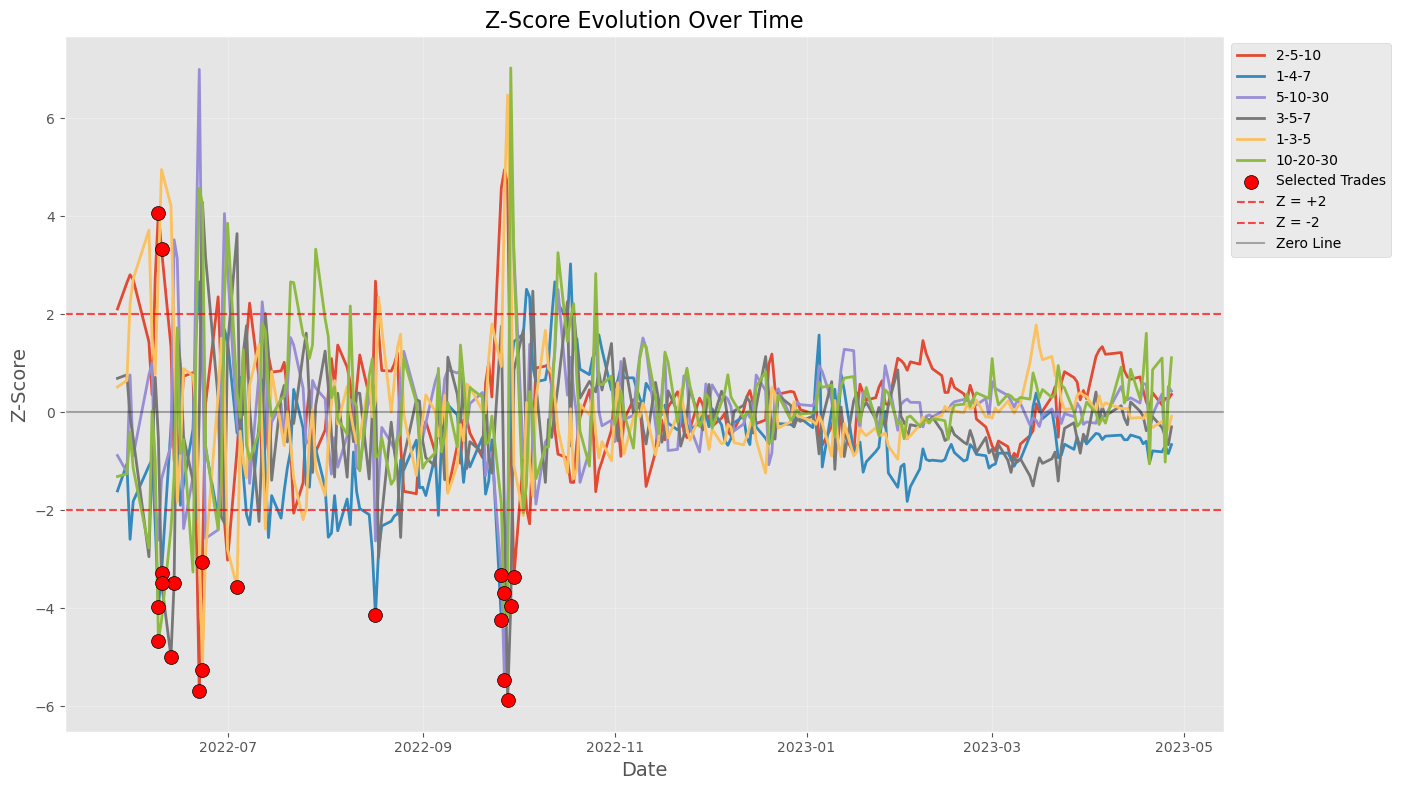

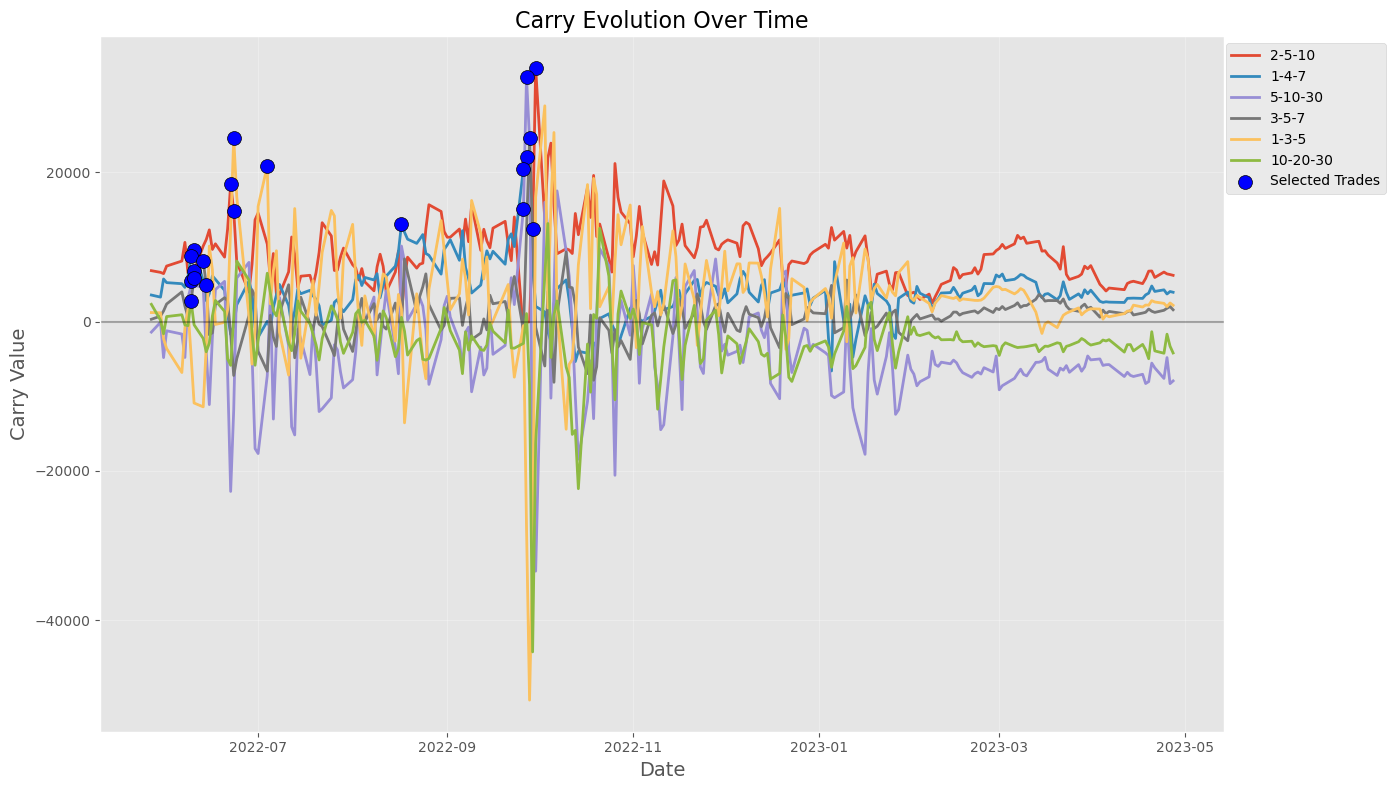

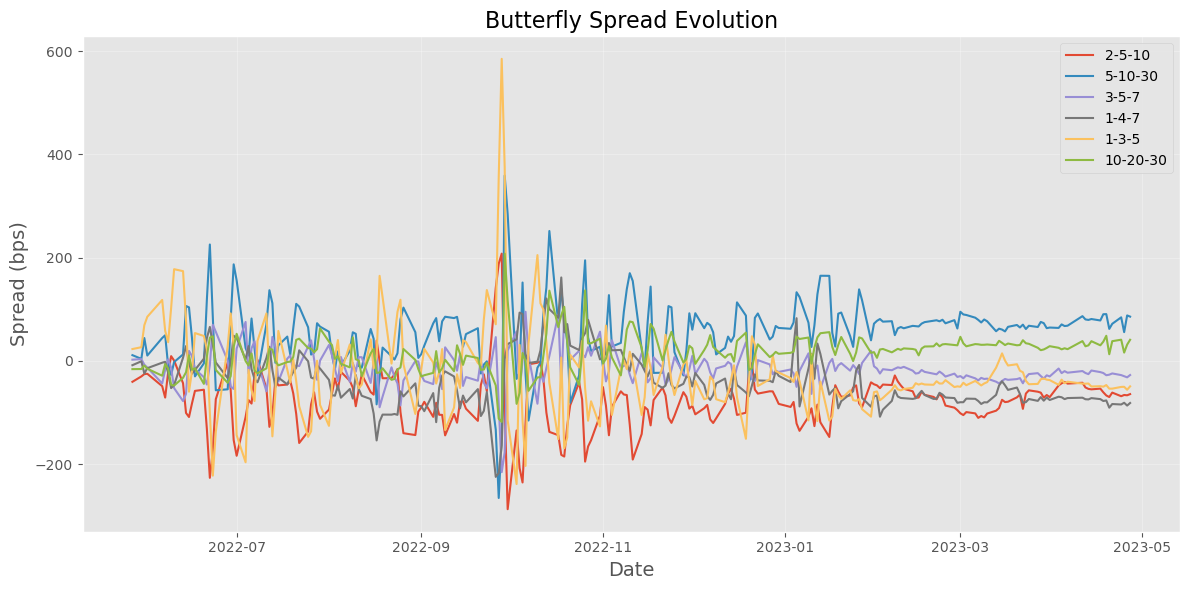

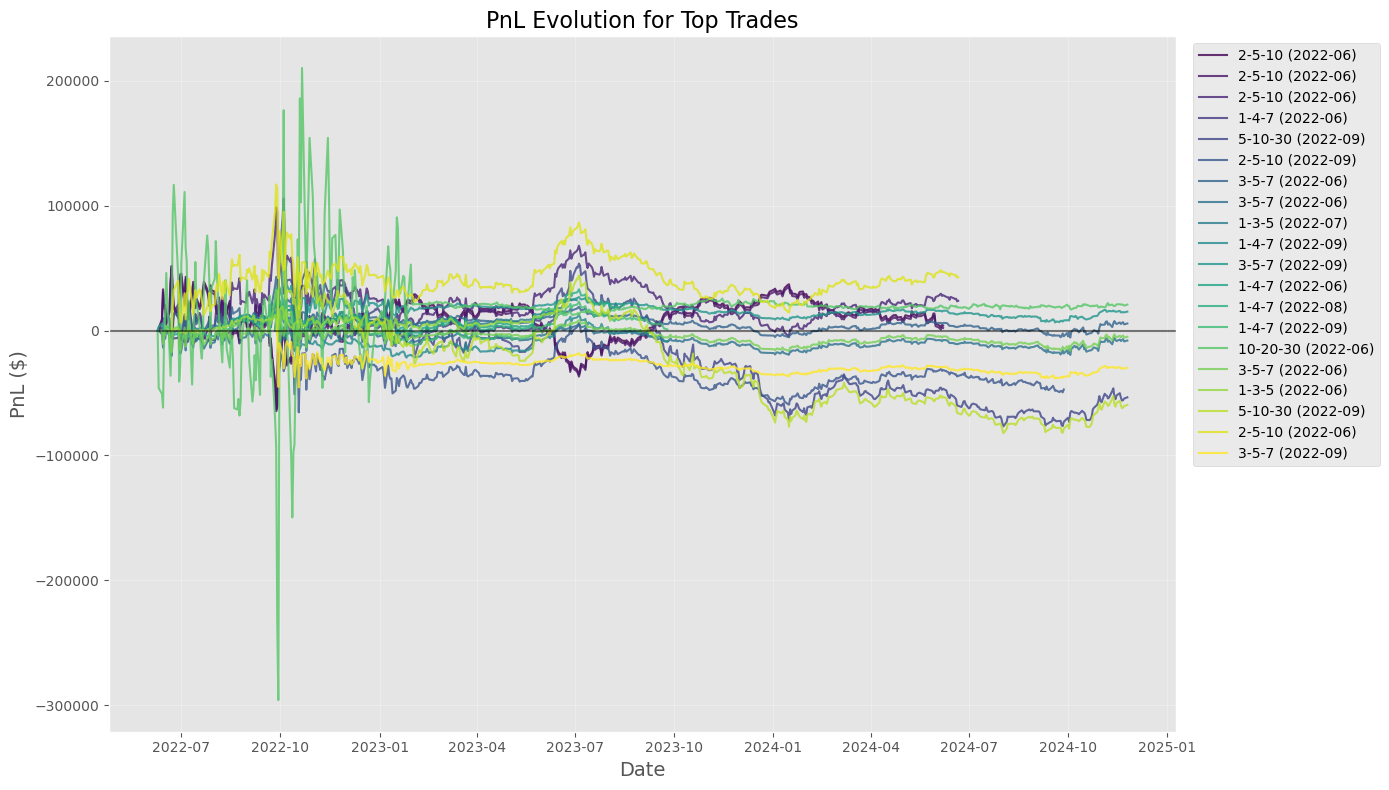

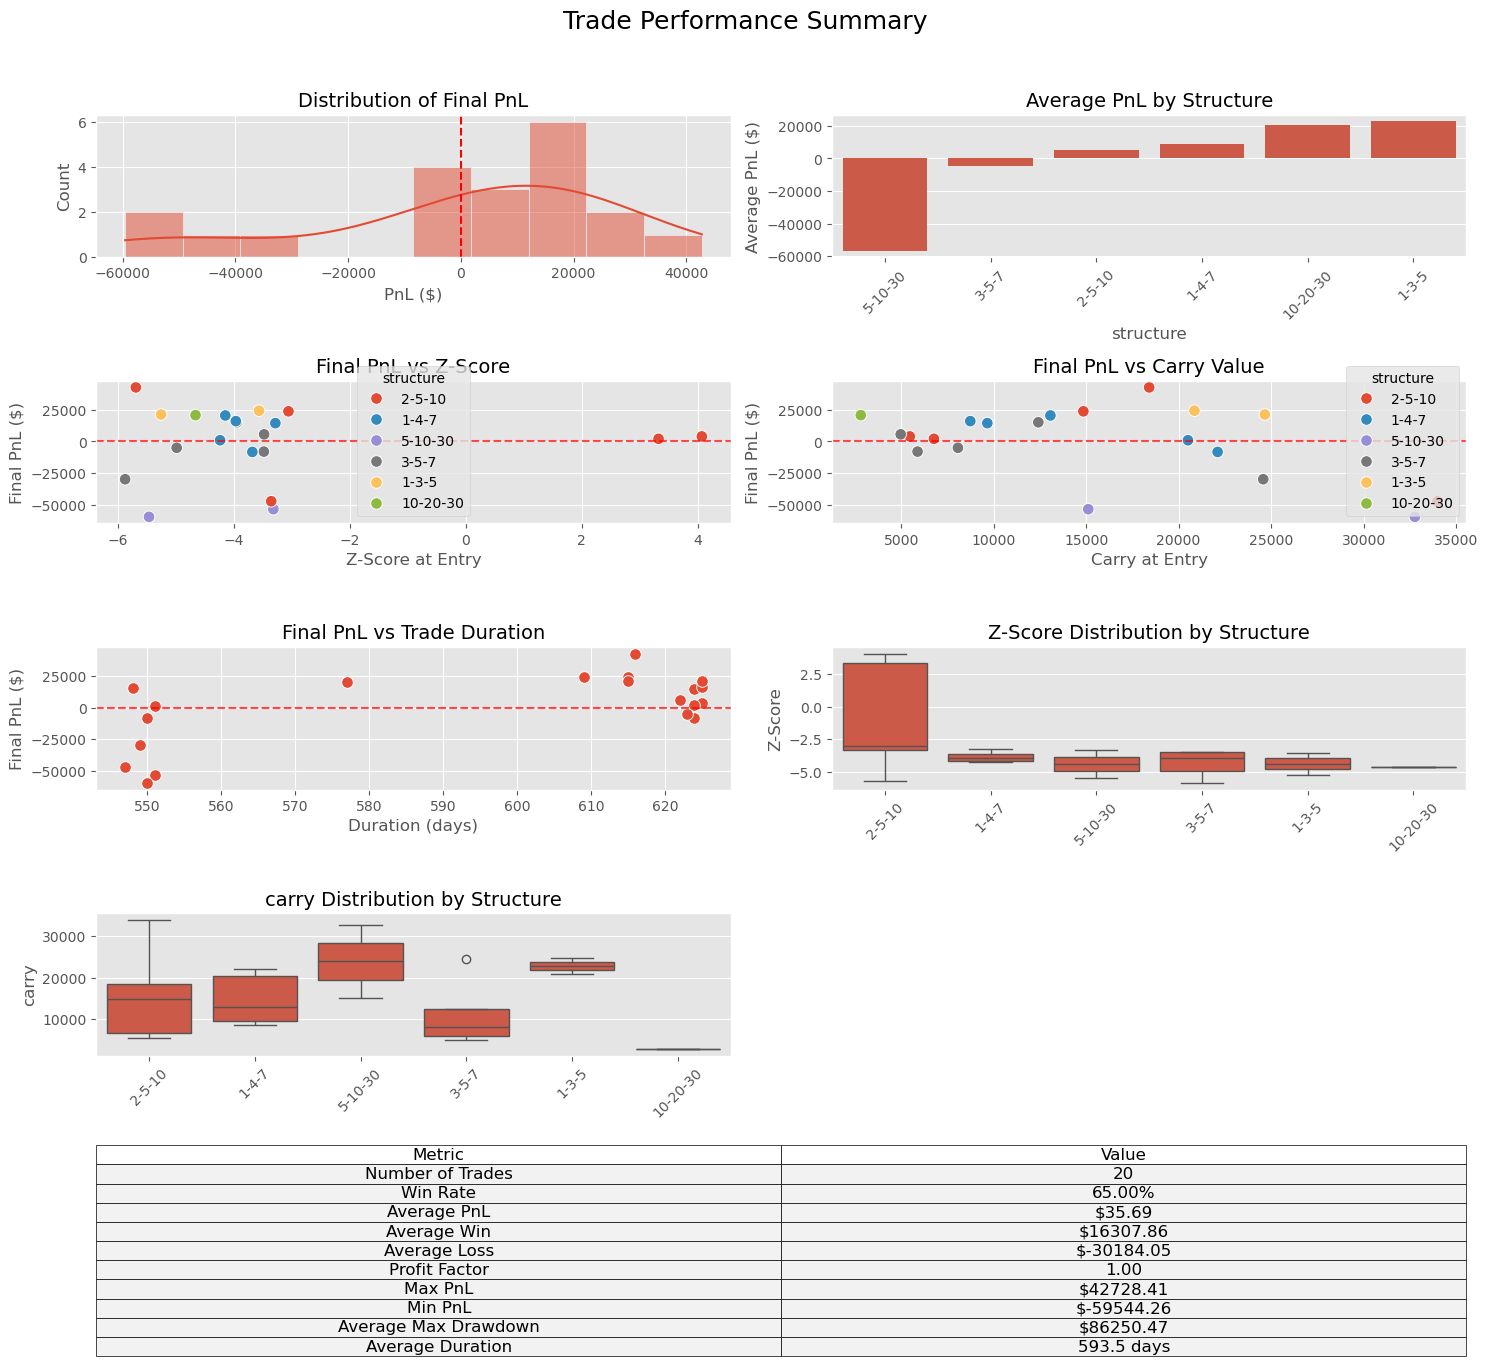

In [66]:
windowuse = 84
z_df = z_dfs[f"window_{windowuse}"]
carry_df = carry_dfs[f"window_{windowuse}"]
fly_df = fly_dfs[f"window_{windowuse}"]
result = results[f"window_{windowuse}"]
best_trades = best_trades_dfs[f"window_{windowuse}"]

plot_zscore_evolution(z_df, best_trades)
plot_carry_evolution(carry_df, best_trades)
plot_fly_evolution(fly_df)
plot_pnl_evolution(result, curves, best_trades, notional=1e6)#
fig = plot_trade_performance(result)